In [1]:
%load_ext autoreload
%autoreload 2

# import functions

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import csv
import importlib
import copy
import pandas as pd
from PIL import Image

import module.dpc as DPC
import module.blc as BLC
import module.lsc as LSC
import module.aaf as AAF
import module.awb as WBGC
# import module.cnf as CNF
import module.cfa as CFA
import module.ccm as CCM
import module.gc  as GC
import module.nr as NR
import module.eeh as EE
import module.bcc as BCC
import module.hsc as HSC

# ImageInfo Class

In [3]:
class ImageInfo:
    def __init__(self, image, domain, bayerPattern, bitNumber) -> None:
        self.image = image
        self.domain = domain
        self.bayerPattern = bayerPattern
        self.bitNumber = bitNumber # bitNumber == -1 means the grayscale in (0,1)
        
    def to_raw(self):
        if self.domain != 'RAW':
            print('Error: Not Raw')
            return
        if type(self.image) is not dict: return
        raw4ChDict = self.image
        img = np.empty( np.array(raw4ChDict['R'].shape)*2 , dtype= raw4ChDict['R'].dtype)
        np.repeat(3, 4)
        match self.bayerPattern:
            case 'RGGB':
                img[::2,::2]   = raw4ChDict['R']
                img[::2,1::2]  = raw4ChDict['Gr']
                img[1::2,::2]  = raw4ChDict['Gb']
                img[1::2,1::2] = raw4ChDict['B']
            case 'BGGR':
                img[::2,::2]   = raw4ChDict['B']
                img[::2,1::2]  = raw4ChDict['Gb']
                img[1::2,::2]  = raw4ChDict['Gr']
                img[1::2,1::2] = raw4ChDict['R']
            case 'GBRG':
                img[::2,::2]   = raw4ChDict['Gb']
                img[::2,1::2]  = raw4ChDict['B']
                img[1::2,::2]  = raw4ChDict['R']
                img[1::2,1::2] = raw4ChDict['Gr']
            case 'GRBG':
                img[::2,::2]   = raw4ChDict['Gr']
                img[::2,1::2]  = raw4ChDict['R']
                img[1::2,::2]  = raw4ChDict['B']
                img[1::2,1::2] = raw4ChDict['Gb']
        self.image = img
        
    def to_4ChDict(self):
        if self.domain != 'RAW':
            print('Error: Not Raw')
            return
        if type(self.image) is dict: return
        img = self.image
        match self.bayerPattern:
            case 'RGGB':
                output = {'R' : img[::2,::2],
                        'Gr': img[::2,1::2],
                        'Gb': img[1::2,::2],
                        'B' : img[1::2,1::2]}
            case 'BGGR':
                output = {'B' : img[::2,::2],
                        'Gb': img[::2,1::2],
                        'Gr': img[1::2,::2],
                        'R' : img[1::2,1::2]}
            case 'GBRG':
                output = {'Gb': img[::2,::2],
                        'B' : img[::2,1::2],
                        'R' : img[1::2,::2],
                        'Gr': img[1::2,1::2]}
            case 'GRBG':
                output = {'Gr': img[::2,::2],
                        'R' : img[::2,1::2],
                        'B' : img[1::2,::2],
                        'Gb': img[1::2,1::2]}
        self.image = output
        
    def to_YUV(self):
        if self.domain == 'RAW':
            print('Error: it\'s Raw')
            return 
        if self.domain == 'YUV': return
        self.image = np.clip(np.squeeze(np.matmul(self.csc[np.newaxis, np.newaxis, :, :3], self.image[:,:,:,np.newaxis])) + self.cscOffset, 0, 255).astype(np.uint8)
        self.domain = 'YUV'
        self.bitNumber = 8
        
    # def to_RGB(self): 
    #     if self.domain == 'RAW':
    #         print('Error: it\'s Raw')
    #         return 
    #     if self.domain is 'RGB': return
    #     self.image = np.clip(np.squeeze(np.matmul(np.linalg.inv(self.csc)[np.newaxis, np.newaxis, :, :3], self.image[:,:,:,np.newaxis] - self.cscOffset)), 0, 1).astype(np.float16)
    #     self.domain = 'RGB'
    #     self.bitNumber = None
        
    def plot(self, YUV = False):
        if self.domain == 'RAW':
            self.to_raw()
            plt.imshow(self.image, vmin = 0, vmax=2**self.bitNumber-1, cmap='gray')
        elif self.domain == 'RGB' or self.domain == 'Y':
            plt.imshow(self.image.astype(np.float32), cmap='gray')
        else: #'YUV'
            if YUV == 'Y':
                plt.imshow(self.image[:,:,0], cmap='gray')
            elif YUV == 'U':
                plt.imshow(self.image[:,:,1], cmap='gray')
            elif YUV == 'V':
                plt.imshow(self.image[:,:,2], cmap='gray')
            else:
                plt.imshow(np.clip(np.squeeze(np.matmul(np.linalg.inv(self.csc)[np.newaxis, np.newaxis, :, :3], (self.image - self.cscOffset)[:,:,:,np.newaxis])), 0, 1).astype(np.float32), cmap='gray')
        plt.show()
        
    def differenceFromPrevious(self, previousImageInfo):
        if self.domain != 'RAW':
            print('Error: Not Raw')
            return None
        self.to_raw()
        previousImageInfo.to_raw()
        return self.image.astype(np.int32) - previousImageInfo.image.astype(np.int32)

# Raw Domain
dtype: np.uint16

## Load RAW

In [4]:
rawInfo = {"path": './raw/test.RAW',
           "shape": [1080, 1920],
           "bayer pattern": 'RGGB',
           "bit number": 10}

In [5]:
rawInfo = {"path": './raw/24 color.raw',
           "shape": [3120, 4160],
           "bayer pattern": 'BGGR',
           "bit number": 10}

AWBData = pd.read_excel('./raw/AWBLSC.xlsx', sheet_name='AWB')
LSCData = pd.read_excel('./raw/AWBLSC.xlsx', sheet_name='LSC')

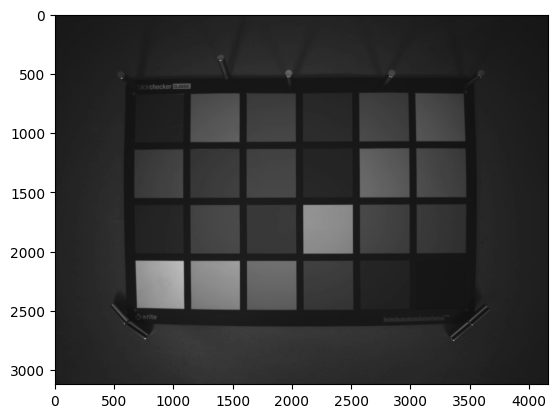

In [6]:
rawImg = np.fromfile(rawInfo['path'], dtype='uint16', sep='')
rawImg = rawImg.reshape(rawInfo['shape'])
rawImage = ImageInfo(rawImg, 'RAW', rawInfo["bayer pattern"], rawInfo["bit number"])
rawImage.plot()

## dead pixel correction

In [7]:
threshold = 30  
mode = 'nearest'
# upLimit = 2**rawInfo["bit number"]-1

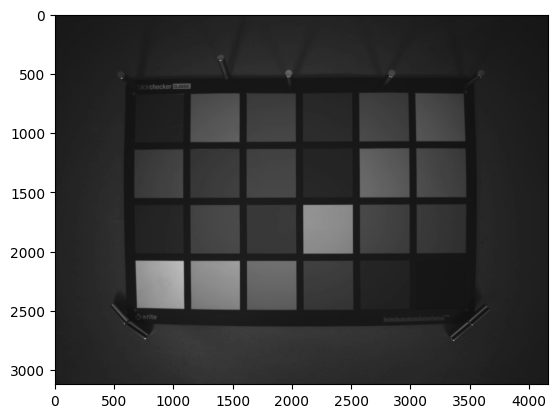

In [8]:
dpcImage = DPC.main(rawImage, threshold, mode)
dpcImage.plot()

0


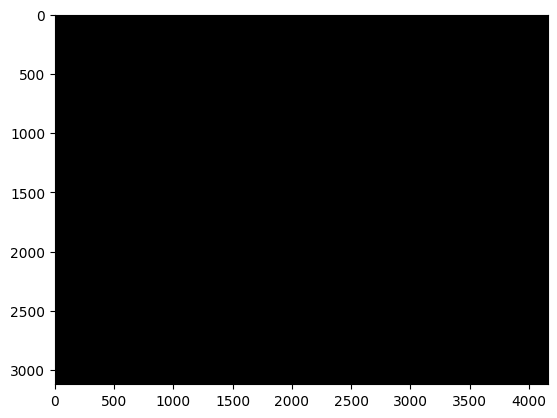

In [9]:
dpc_pos = dpcImage.differenceFromPrevious(rawImage)
dpc_pos[dpc_pos != 0] = 1
plt.imshow(dpc_pos, cmap='gray')
print(sum(dpc_pos.flatten()))

## black level compensation

In [10]:
parameters = [8]*6 # [bl_r, bl_gr, bl_gb, bl_b, alpha, beta]

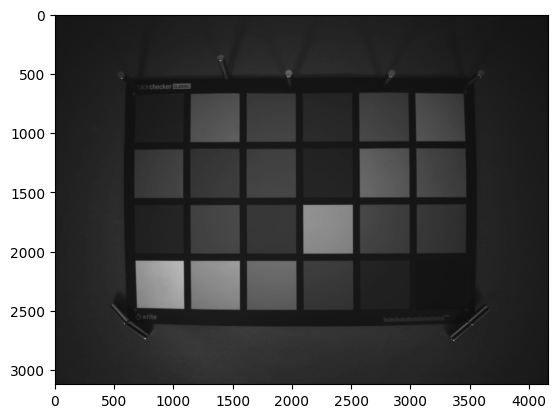

In [11]:
blcImage = BLC.main(dpcImage, parameters)
blcImage.plot()

## lens shading correction

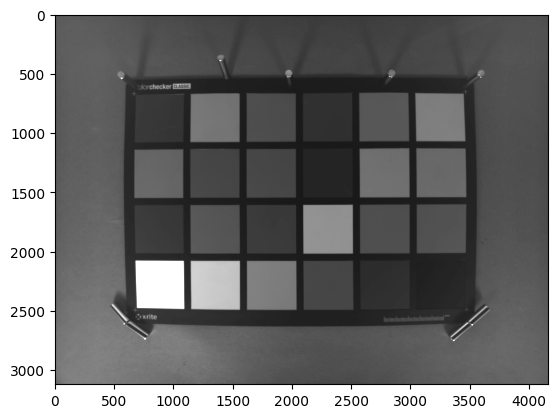

In [12]:
lscImage = LSC.main(blcImage, LSCData, 'Qualcomm')
lscImage.plot()

## anti-aliasing filter (spatial filter)

In [13]:
mode = 'lowpass'

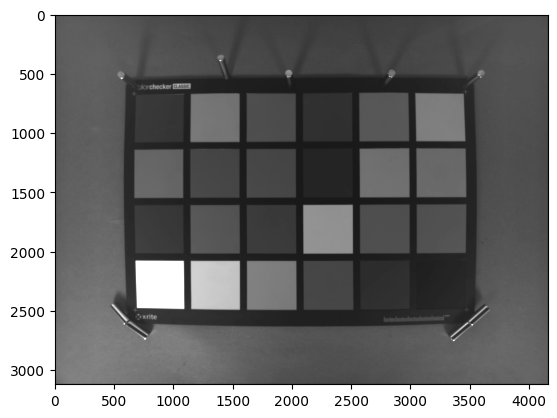

In [14]:
aafImage = AAF.main(lscImage, mode)
aafImage.plot()

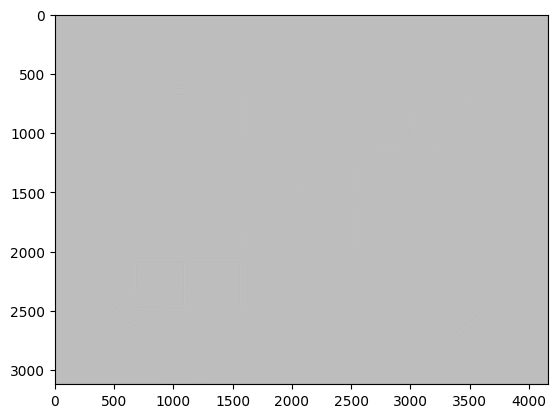

In [15]:
rawImg_diff = aafImage.differenceFromPrevious(lscImage)
plt.imshow(rawImg_diff, cmap='gray')
plt.show()

## HDR/Tone Mapping

In [16]:
hdrImage = copy.deepcopy(aafImage)

## white balance gain control

In [17]:
parameters = [1/AWBData.RG[0], 1.0, 1.0, 1/AWBData.BG[0]]#[r_gain, gr_gain, gb_gain, b_gain]

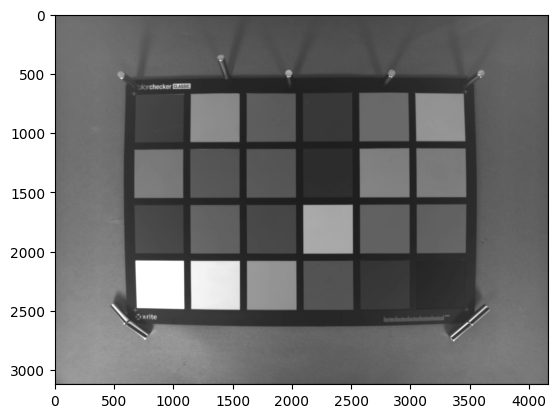

In [18]:
awbImage = WBGC.main(hdrImage, parameters)
awbImage.plot()

## chroma noise filtering
* don't understand the algorithm yet.
* not sure should it be here yet.
* there are model for it in 'model' folder

In [19]:
cnfImage = copy.deepcopy(awbImage)

## color filter array interpolation (demosaicing)
RAW to RGB in [0, 1]

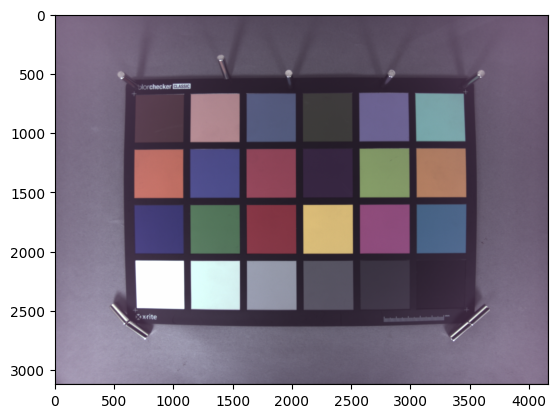

In [20]:
cfaImage = CFA.main(cnfImage)
cfaImage.plot()

# RGB Domain
3 channel

## color correction matrix

In [21]:
ccm = np.array([[0.95, 0.05, 0.05, -0.05],
                [0.05, 0.95, 0.05, -0.05],
                [0.05, 0.05, 0.95, -0.05]])

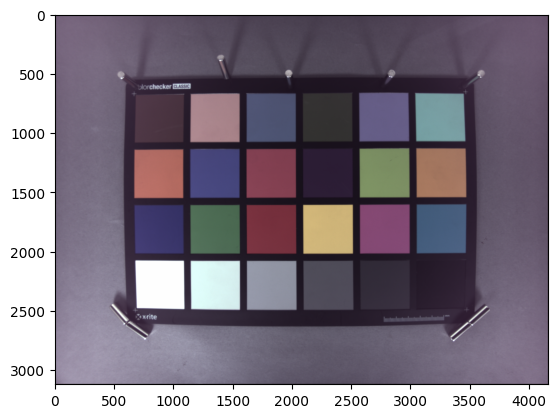

In [22]:
ccmImage = CCM.main(cfaImage, ccm)
ccmImage.plot()

## gamma correction

In [23]:
# didn't use look up table
import module.gc  as GC
gamma = 0.8

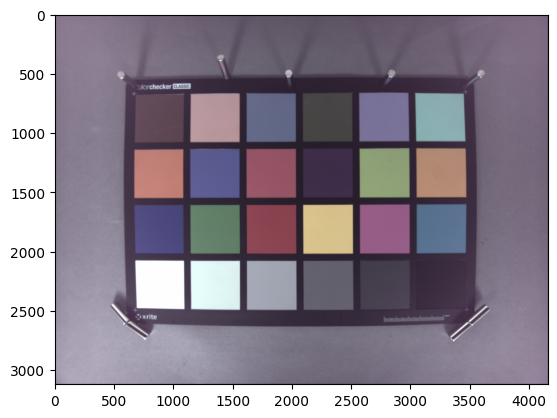

In [24]:
gcImage = GC.main(ccmImage, gamma)
gcImage.plot()

## color space conversion
RGB to YUV in [0, 255]

In [25]:
csc = 256*np.array([[ 0.257,  0.504,  0.098],
                    [-0.148, -0.291,  0.439],
                    [ 0.439, -0.368, -0.071]])
cscOffset = np.array([ 16., 128., 128.])

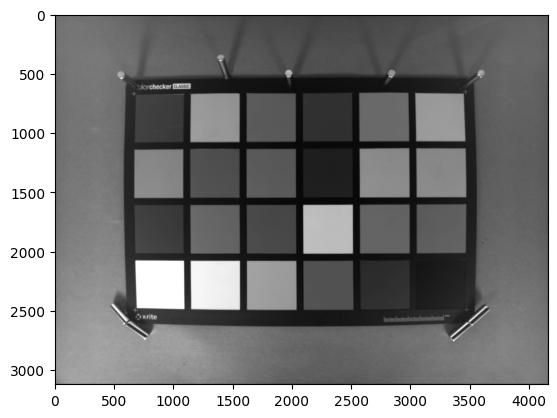

In [26]:
cscImage = copy.deepcopy(gcImage)
cscImage.csc = csc
cscImage.cscOffset = cscOffset
cscImage.to_YUV()
cscImage.plot('Y')

# YUV Domain
16 bit (8-bit * 3 channel)

## (YUV) Noise Reduction

In [27]:
parameters = [3, 5, 1] # [windowSize, sigmaI, sigmaD]

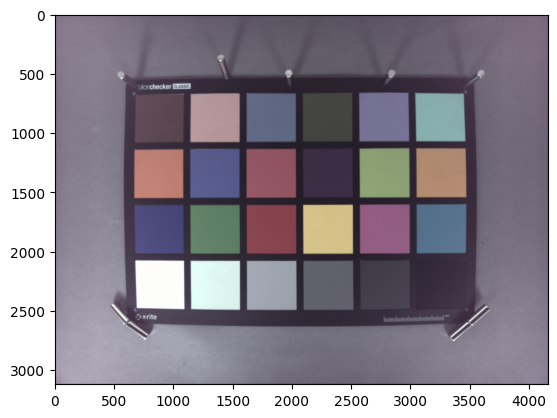

In [28]:
nrImage = NR.main(cscImage, *parameters)
nrImage.plot()

## (Y) edge enhancement

In [29]:
edgeFilter =  np.array([[-.25,  0., -0.5,  0., -.25],
                        [-.5 ,  0.5,  4.,  0.5, -.5 ],
                        [-.25,  0., -0.5,  0., -.25]])
edgeFilter = edgeFilter/np.sum(edgeFilter)

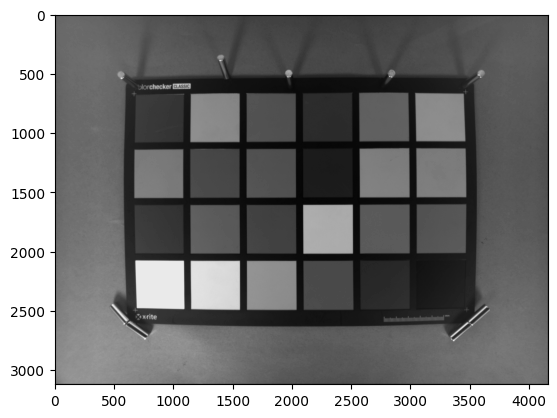

In [30]:
eeImage = EE.main(nrImage, edgeFilter)
eeImage.plot('Y')

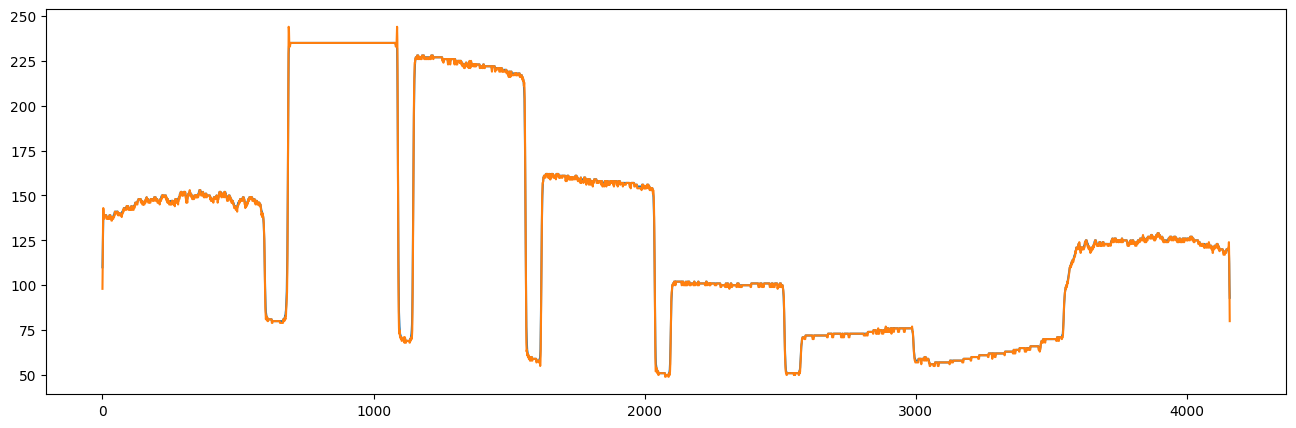

In [31]:
# plt.plot(cscImage.image[2300,500:1000,0])
plt.plot(nrImage.image[2300,:,0])
plt.plot(eeImage.image[2300,:,0])
plt.gcf().set_size_inches(16,5)

## (Y) brightness/contrast control

In [32]:
brightness = -15
contrast = 1.3

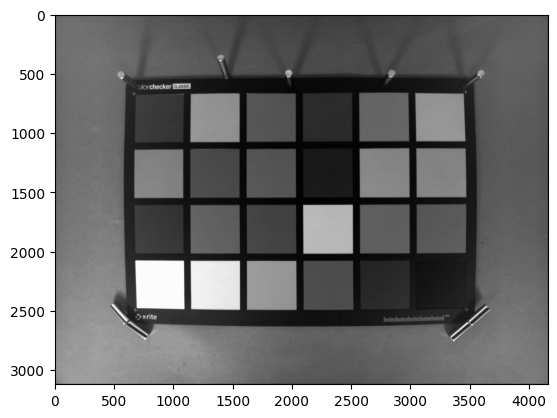

In [33]:
bccImage = BCC.main(eeImage, brightness, contrast)
bccImage.plot('Y')

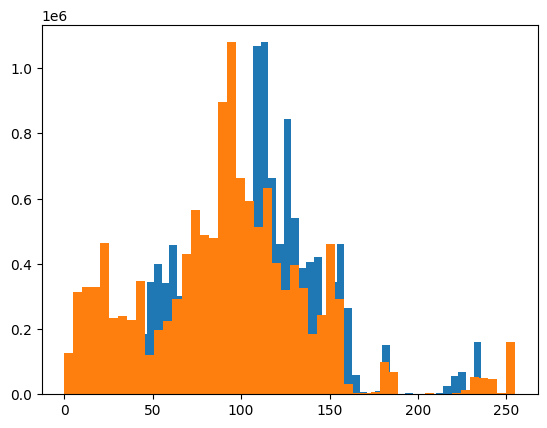

In [34]:
plt.hist(eeImage.image[:,:,0].flatten(), 50)
plt.hist(bccImage.image[:,:,0].flatten(), 50)
plt.show()

## (UV) hue/saturation control

In [35]:
hueTheta = np.pi/6*0
saturation = 2

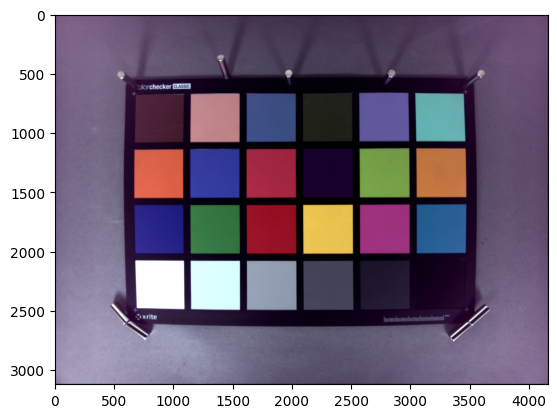

In [36]:
hscImage = HSC.main(bccImage, hueTheta, saturation)
hscImage.plot()
# Image.fromarray(hscImage.image,mode = 'YCbCr').show()

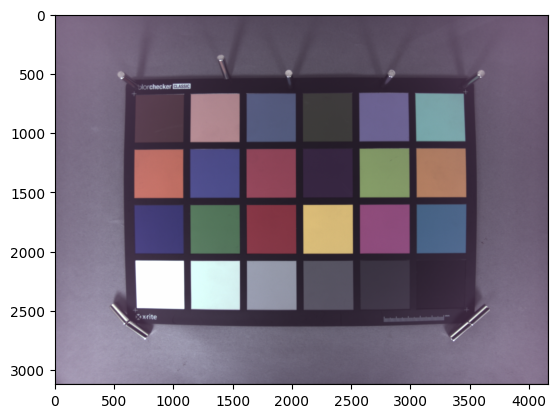

In [37]:
cfaImage.plot()

In [51]:
Image.fromarray(hscImage.image, mode = 'YCbCr').show()

In [50]:
Image.fromarray((cfaImage.image*255).astype(np.uint8), mode = 'RGB').show()